In [3]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

df = pd.read_csv("../../yikyak_metadata.csv")

TEXT_COL = "text_clean"
LABEL_COL = "high_engagement"

NUM_COLS = [
     "text_length", "created_hour", "first_person_count", "second_person_count", "first_person_ratio", "second_person_ratio",
    "disagree_count",  "conflict_count",  "exclamations", "questions",  "vader_compound",
    "posts_prev_2h_all",
"rel_posts_prev_2h",
"burst_z_group",
"burst_flag_group",
]
use_cols = [TEXT_COL, LABEL_COL] + NUM_COLS
df_model = df[use_cols].dropna().copy()

df_model[NUM_COLS] = df_model[NUM_COLS].replace([np.inf, -np.inf], np.nan)
df_model[NUM_COLS] = df_model[NUM_COLS].fillna(0)


X_train_df, X_test_df = train_test_split(
    df_model,
    test_size=0.2,
    random_state=42,
    stratify=df_model[LABEL_COL]
)

y_train = X_train_df[LABEL_COL].values
y_test  = X_test_df[LABEL_COL].values


tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,2),
    min_df=2
)

X_train = tfidf.fit_transform(X_train_df[TEXT_COL])
X_test  = tfidf.transform(X_test_df[TEXT_COL])



svm = LinearSVC(
    C=2.5,
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)

svm.fit(X_train, y_train)


y_pred = svm.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      3443
           1       0.18      0.30      0.23       382

    accuracy                           0.80      3825
   macro avg       0.55      0.58      0.55      3825
weighted avg       0.84      0.80      0.82      3825

Confusion Matrix:
[[2933  510]
 [ 268  114]]


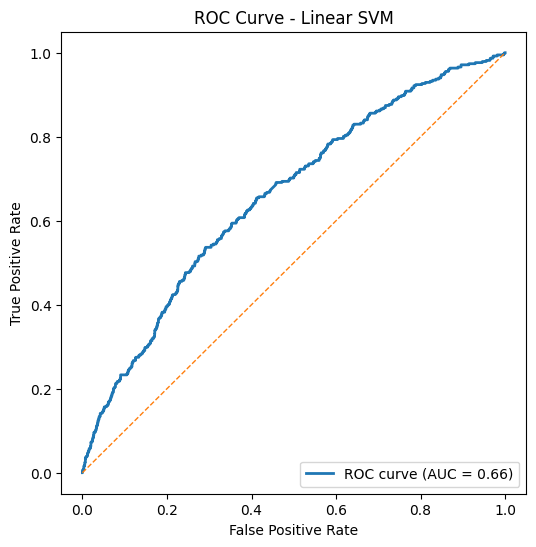

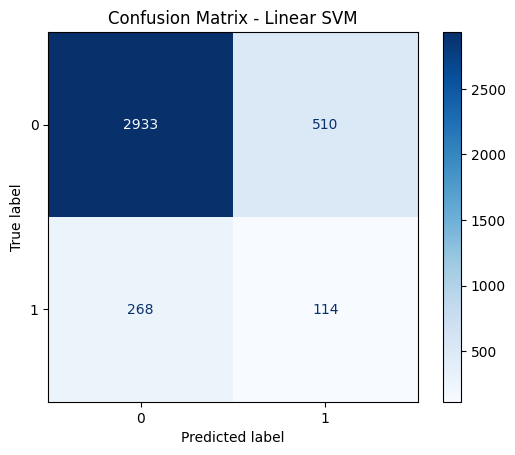

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Get decision scores (NOT probabilities)
y_scores = svm.decision_function(X_test)

# ROC curve + AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Linear SVM')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix (uses default decision boundary)
ConfusionMatrixDisplay.from_estimator(
    svm,
    X_test,
    y_test,
    cmap='Blues'
)
plt.title('Confusion Matrix - Linear SVM')
plt.show()
